# Використання рекурентних нейронних мереж для прогнозування часових рядів і тексту

## Мета

Вивчити основи роботи з рекурентними нейронними мережами (RNN) на прикладі прогнозування часових рядів та генерування тексту.

### Частина 1: Прогнозування часових рядів

### Крок 1: Імпорт бібліотек

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import TextVectorization, Embedding, Dense, SimpleRNN, Input, LSTM, GRU
from keras.utils import plot_model
from keras.callbacks import EarlyStopping

In [158]:
HOURS_IN_DAY = 24
LOOK_BACK = 30
UNITS = 128
EPOCHS = 100
MAX_TOKENS = 5000
EMBEDDING_DIM = 128
OUTPUT_DIM = 64
BATCH_SIZE = 32
MAX_SEQUENCE_LENGTH = 5
DATASETS = 'datasets/'

### Крок 2: Завантаження та підготовка даних

In [4]:
female_births_df = pd.read_csv(DATASETS + "female-births.csv")

female_births_df

,Date,Births
0,1959-01-01,35
1,1959-01-02,32
2,1959-01-03,30
3,1959-01-04,31
4,1959-01-05,44
...,...,...
360,1959-12-27,37
361,1959-12-28,52
362,1959-12-29,48
363,1959-12-30,55


In [5]:
female_births_df['Datetime'] = pd.to_datetime(female_births_df['Date'])

# female_births_df['Day_of_week'] = female_births_df['Datetime'].dt.dayofweek
female_births_df['Day'] = female_births_df['Datetime'].dt.day
female_births_df['Month'] = female_births_df['Datetime'].dt.month
female_births_df['Year'] = female_births_df['Datetime'].dt.year
# female_births_df['Is_Weekend'] = (female_births_df['Day_of_week']  >= WORKING_DAYS).astype(int)

female_births_df

,Date,Births,Datetime,Day,Month,Year
0,1959-01-01,35,1959-01-01,1,1,1959
1,1959-01-02,32,1959-01-02,2,1,1959
2,1959-01-03,30,1959-01-03,3,1,1959
3,1959-01-04,31,1959-01-04,4,1,1959
4,1959-01-05,44,1959-01-05,5,1,1959
...,...,...,...,...,...,...
360,1959-12-27,37,1959-12-27,27,12,1959
361,1959-12-28,52,1959-12-28,28,12,1959
362,1959-12-29,48,1959-12-29,29,12,1959
363,1959-12-30,55,1959-12-30,30,12,1959


In [6]:
female_births_features = female_births_df[['Births', 'Day', 'Month', 'Year']] #, 'Day_of_week','Is_Weekend'

female_births_features

,Births,Day,Month,Year
0,35,1,1,1959
1,32,2,1,1959
2,30,3,1,1959
3,31,4,1,1959
4,44,5,1,1959
...,...,...,...,...
360,37,27,12,1959
361,52,28,12,1959
362,48,29,12,1959
363,55,30,12,1959


In [7]:
female_births_target = female_births_features[['Births']]

female_births_target

,Births
0,35
1,32
2,30
3,31
4,44
...,...
360,37
361,52
362,48
363,55


In [8]:
female_births_features_array = np.array(female_births_features.values)

female_births_features_array

array([[  35,    1,    1, 1959],
       [  32,    2,    1, 1959],
       [  30,    3,    1, 1959],
       ...,
       [  48,   29,   12, 1959],
       [  55,   30,   12, 1959],
       [  50,   31,   12, 1959]])

In [9]:
female_births_target_array = np.array(female_births_target.values)

female_births_target_array

array([[35],
       [32],
       [30],
       [31],
       [44],
       [29],
       [45],
       [43],
       [38],
       [27],
       [38],
       [33],
       [55],
       [47],
       [45],
       [37],
       [50],
       [43],
       [41],
       [52],
       [34],
       [53],
       [39],
       [32],
       [37],
       [43],
       [39],
       [35],
       [44],
       [38],
       [24],
       [23],
       [31],
       [44],
       [38],
       [50],
       [38],
       [51],
       [31],
       [31],
       [51],
       [36],
       [45],
       [51],
       [34],
       [52],
       [47],
       [45],
       [46],
       [39],
       [48],
       [37],
       [35],
       [52],
       [42],
       [45],
       [39],
       [37],
       [30],
       [35],
       [28],
       [45],
       [34],
       [36],
       [50],
       [44],
       [39],
       [32],
       [39],
       [45],
       [43],
       [39],
       [31],
       [27],
       [30],
       [42],
       [46],

In [10]:
features_scaler = MinMaxScaler(feature_range=(0, 1))
features_scaled_data = features_scaler.fit_transform(female_births_features.values)

features_scaled_data

array([[0.24      , 0.        , 0.        , 0.        ],
       [0.18      , 0.03333333, 0.        , 0.        ],
       [0.14      , 0.06666667, 0.        , 0.        ],
       ...,
       [0.5       , 0.93333333, 1.        , 0.        ],
       [0.64      , 0.96666667, 1.        , 0.        ],
       [0.54      , 1.        , 1.        , 0.        ]])

In [11]:
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled_data = target_scaler.fit_transform(female_births_target.values)

target_scaled_data

array([[0.24],
       [0.18],
       [0.14],
       [0.16],
       [0.42],
       [0.12],
       [0.44],
       [0.4 ],
       [0.3 ],
       [0.08],
       [0.3 ],
       [0.2 ],
       [0.64],
       [0.48],
       [0.44],
       [0.28],
       [0.54],
       [0.4 ],
       [0.36],
       [0.58],
       [0.22],
       [0.6 ],
       [0.32],
       [0.18],
       [0.28],
       [0.4 ],
       [0.32],
       [0.24],
       [0.42],
       [0.3 ],
       [0.02],
       [0.  ],
       [0.16],
       [0.42],
       [0.3 ],
       [0.54],
       [0.3 ],
       [0.56],
       [0.16],
       [0.16],
       [0.56],
       [0.26],
       [0.44],
       [0.56],
       [0.22],
       [0.58],
       [0.48],
       [0.44],
       [0.46],
       [0.32],
       [0.5 ],
       [0.28],
       [0.24],
       [0.58],
       [0.38],
       [0.44],
       [0.32],
       [0.28],
       [0.14],
       [0.24],
       [0.1 ],
       [0.44],
       [0.22],
       [0.26],
       [0.54],
       [0.42],
       [0.

In [12]:
x_train, y_train = [], []
total = len(features_scaled_data) - LOOK_BACK

for index in range(total):
    x_train.append(features_scaled_data[index:index + LOOK_BACK])
    y_train.append(features_scaled_data[index + LOOK_BACK][0])

x_train = np.array(x_train)
y_train = np.array(y_train)

x_train, y_train

(array([[[0.24      , 0.        , 0.        , 0.        ],
         [0.18      , 0.03333333, 0.        , 0.        ],
         [0.14      , 0.06666667, 0.        , 0.        ],
         ...,
         [0.24      , 0.9       , 0.        , 0.        ],
         [0.42      , 0.93333333, 0.        , 0.        ],
         [0.3       , 0.96666667, 0.        , 0.        ]],
 
        [[0.18      , 0.03333333, 0.        , 0.        ],
         [0.14      , 0.06666667, 0.        , 0.        ],
         [0.16      , 0.1       , 0.        , 0.        ],
         ...,
         [0.42      , 0.93333333, 0.        , 0.        ],
         [0.3       , 0.96666667, 0.        , 0.        ],
         [0.02      , 1.        , 0.        , 0.        ]],
 
        [[0.14      , 0.06666667, 0.        , 0.        ],
         [0.16      , 0.1       , 0.        , 0.        ],
         [0.42      , 0.13333333, 0.        , 0.        ],
         ...,
         [0.3       , 0.96666667, 0.        , 0.        ],
        

### Крок 3: Створення та навчання моделі

In [13]:
INPUT_SHAPE = shape=(LOOK_BACK, len(female_births_features.columns))

INPUT_SHAPE

(30, 4)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 128)            │        17,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,153 (67.00 KB)

 Trainable params: 17,153 (67.00 KB)

 Non-trainable params: 0 (0.00 B)

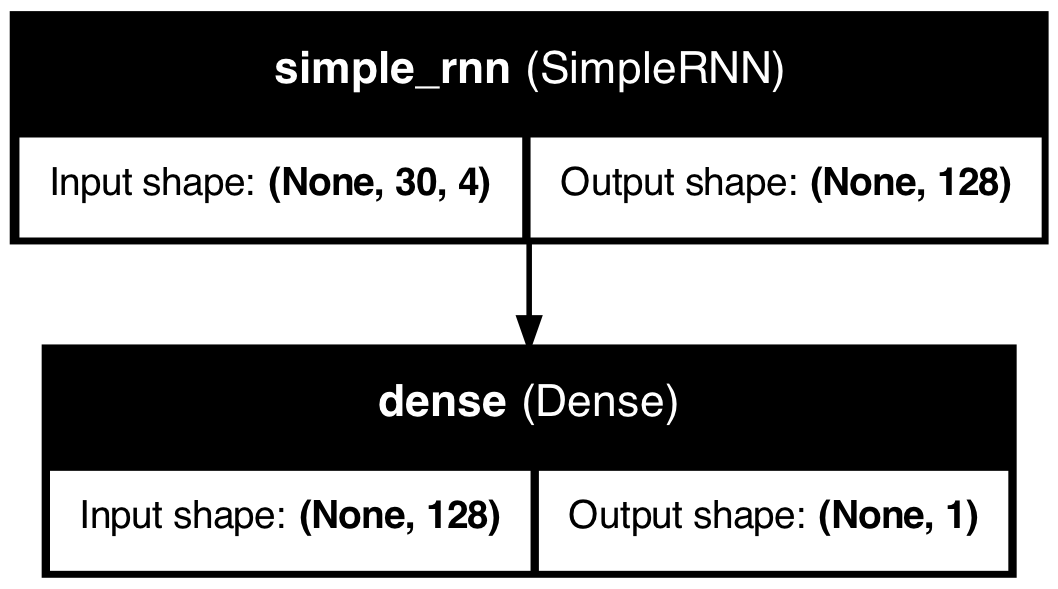

In [14]:
model_simple_rnn = Sequential()
model_simple_rnn.add(Input(shape=INPUT_SHAPE))
model_simple_rnn.add(SimpleRNN(UNITS, activation='relu'))
model_simple_rnn.add(Dense(1))

model_simple_rnn.compile(optimizer='adam', loss='mean_squared_error')
model_simple_rnn.summary()

plot_model(model_simple_rnn, to_file="model_simple_rnn.png", show_shapes=True, show_layer_names=True)

In [15]:
earlyStopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

In [16]:
history_simple_rnn = model_simple_rnn.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, callbacks=[earlyStopping])

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0271  
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0219 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0202 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0205 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0190 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0198 
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0167 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0164 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0184 
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0179 
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0162 
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0165 
Epoch 13/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0158 
Epoch 14/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0161 
Epoch 15/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

In [17]:
female_birth_predictions = model_simple_rnn.predict(x_train)

female_birth_predictions

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


array([[0.01900483],
       [0.00434239],
       [0.16040106],
       [0.40859172],
       [0.30295697],
       [0.54933065],
       [0.29805598],
       [0.571164  ],
       [0.15600656],
       [0.16805828],
       [0.56975996],
       [0.25611395],
       [0.4559924 ],
       [0.57058084],
       [0.21255806],
       [0.5991742 ],
       [0.4875466 ],
       [0.43453065],
       [0.47228447],
       [0.32582644],
       [0.50382227],
       [0.27741262],
       [0.24246386],
       [0.581006  ],
       [0.3882311 ],
       [0.4174402 ],
       [0.3185341 ],
       [0.27999762],
       [0.12211898],
       [0.21749699],
       [0.08828014],
       [0.437549  ],
       [0.22757356],
       [0.27029228],
       [0.5407412 ],
       [0.40629324],
       [0.32272413],
       [0.17989755],
       [0.3157937 ],
       [0.45788068],
       [0.4073046 ],
       [0.33345157],
       [0.160558  ],
       [0.08797514],
       [0.15027572],
       [0.39223298],
       [0.462568  ],
       [0.369

In [18]:
inverted_female_birth_predictions = target_scaler.inverse_transform(female_birth_predictions)

inverted_female_birth_predictions

array([[23.950241],
       [23.21712 ],
       [31.020054],
       [43.429585],
       [38.14785 ],
       [50.46653 ],
       [37.902798],
       [51.5582  ],
       [30.800327],
       [31.402912],
       [51.488   ],
       [35.805695],
       [45.799618],
       [51.529045],
       [33.627903],
       [52.95871 ],
       [47.37733 ],
       [44.726532],
       [46.614223],
       [39.29132 ],
       [48.191113],
       [36.870632],
       [35.12319 ],
       [52.050297],
       [42.411552],
       [43.87201 ],
       [38.926704],
       [36.99988 ],
       [29.10595 ],
       [33.874847],
       [27.414005],
       [44.87745 ],
       [34.378677],
       [36.514614],
       [50.037064],
       [43.314663],
       [39.136208],
       [31.994877],
       [38.789684],
       [45.89403 ],
       [43.36523 ],
       [39.672577],
       [31.0279  ],
       [27.398756],
       [30.513786],
       [42.61165 ],
       [46.128403],
       [41.454105],
       [36.129665],
       [45.127087],


In [19]:
def draw_history(history):
      history_data = history.history

      epochs = range(len(history_data['loss']))
      plt.figure(figsize=(20, 8))
      plt.subplot(121)
      plt.plot(epochs, history_data['loss'], '.-')
      plt.grid(True)
      plt.xlabel('Epochs')
      plt.ylabel('Loss')

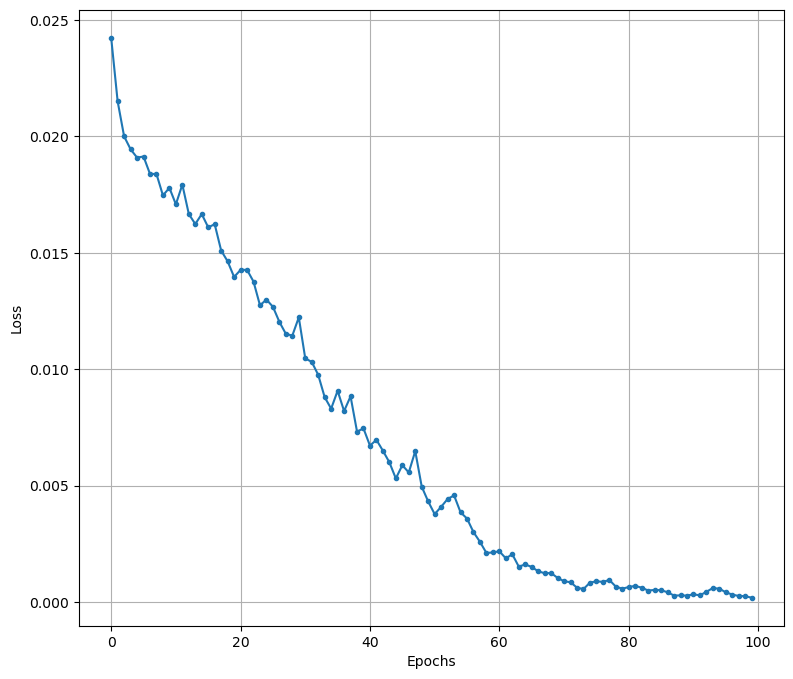

In [20]:
draw_history(history_simple_rnn)

In [21]:
def draw_predictions(female_births_target_array, inverted_female_birth_predictions):
      plt.figure(figsize=(20, 10))
      plt.plot(female_births_target_array, color='blue', label='Actual Data')
      plt.plot(inverted_female_birth_predictions.astype(int), color='red', label='Predicted Data')
      plt.title('Time Series Prediction')
      plt.ylabel('Total Births')
      plt.legend()
      plt.show()

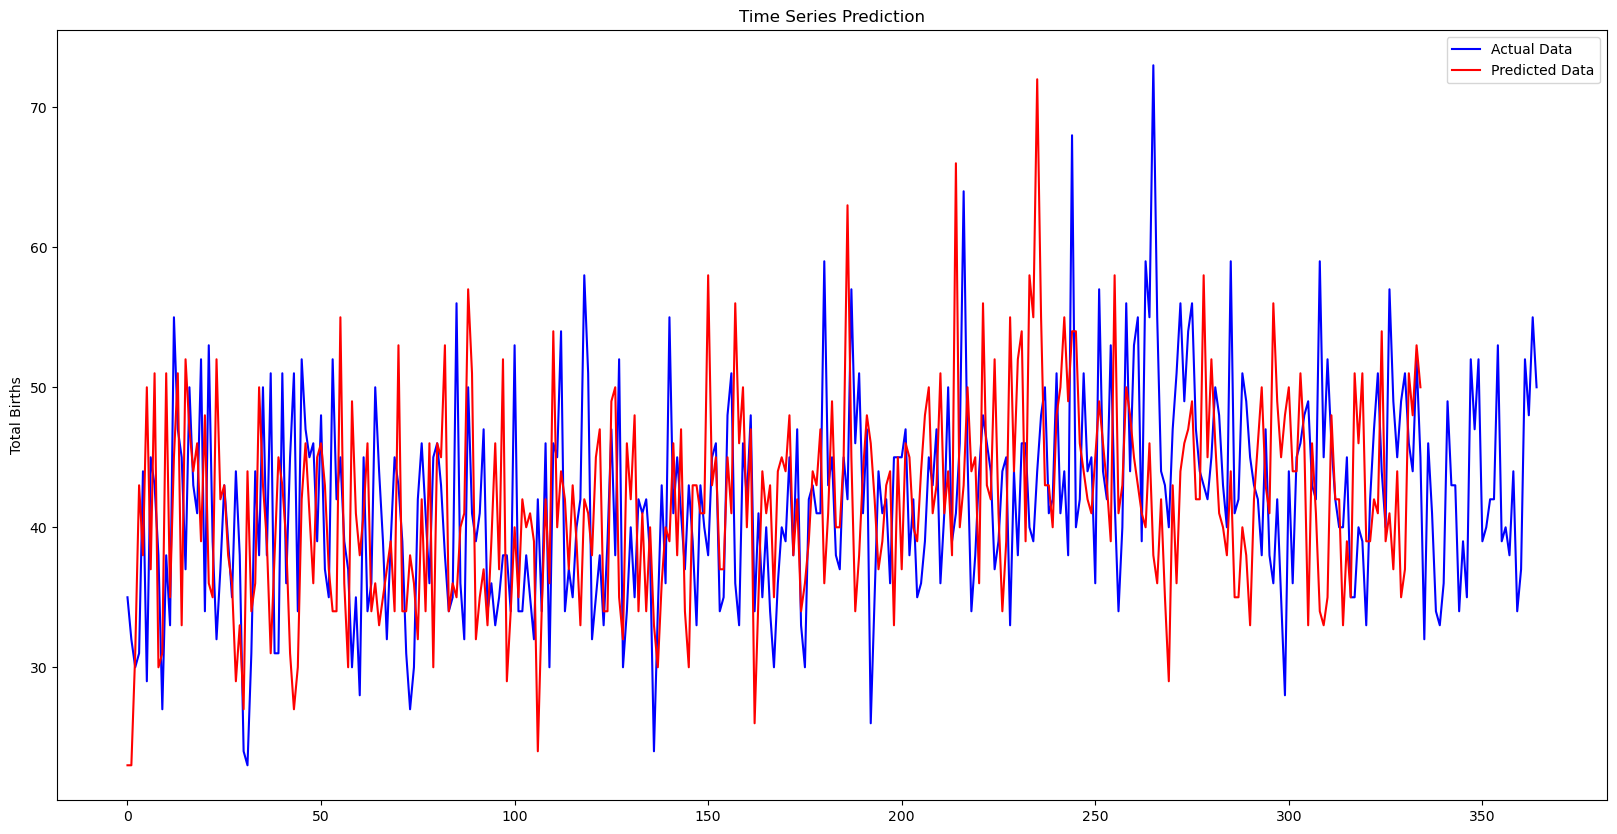

In [22]:
draw_predictions(female_births_target_array, inverted_female_birth_predictions)

## Частина 2: Генерація тексту

### Крок 1: Імпорт бібліотек

### Крок 2: Підготовка текстових даних


In [177]:
text_bank = open(DATASETS + 'А_зори_здесь_тихие.txt', 'r', encoding='utf-8').read()
text_rows_bank =  [row for row in text_bank.split('\n') if row.strip() != '']

text_rows_bank

['На 171-м разъезде уцелело двенадцать дворов, пожарный сарай да приземистый длинный пакгауз, выстроенный в начале века из подогнанных валунов. В последнюю бомбежку рухнула водонапорная башня, и поезда перестали здесь останавливаться, Немцы прекратили налеты, но кружили над разъездом ежедневно, и командование на всякий случай держало там две зенитные счетверенки.',
 'Шел май 1942 года. На западе (в сырые ночи оттуда доносило тяжкий гул артиллерии) обе стороны, на два метра врывшись в землю, окончательно завязли в позиционной войне; на востоке немцы день и ночь бомбили канал и Мурманскую дорогу; на севере шла ожесточенная борьба за морские пути; на юге продолжал упорную борьбу блокированный Ленинград.',
 'А здесь был курорт. От тишины и безделья солдаты млели, как в парной, а в двенадцати дворах оставалось еще достаточно молодух и вдовушек, умевших добывать самогон чуть ли не из комариного писка. Три дня солдаты отсыпались и присматривались; на четвертый начинались чьи-то именины, и над

In [179]:
vectorizer = TextVectorization(output_mode='int', output_sequence_length=MAX_SEQUENCE_LENGTH + 1)

vectorizer.adapt(text_rows_bank)

vectorizer

<TextVectorization name=text_vectorization_6, built=False>

In [180]:
vectorized_output = vectorizer(text_rows_bank)

vectorized_output

<tf.Tensor: shape=(139, 6), dtype=int64, numpy=
array([[  52, 2062,  249,  513, 1623, 1616],
       [1876, 1311, 2061, 1663,   52, 1484],
       [  11,  326,   51, 1345,  183,  602],
       [ 394,  250,  489,   23,   53,  274],
       [   2, 1881, 1487,    2, 1644,  924],
       [   2, 1874,  295,    2,  532,  614],
       [   2, 2017,    8,  161,    0,    0],
       [   2, 2046, 1768,    2,  150, 1664],
       [   2,  393, 2045,    2,  843,   15],
       [   2,  111,  121,    2, 1590,  233],
       [1981,  565,    5, 1699, 1435, 1452],
       [   2, 2037,  736,    2,  936,   23],
       [1954,   41, 1157,  152, 1204,   29],
       [   2,  378,  317,   96,    0,    0],
       [   2,   61,  943,   34,   35,    0],
       [   2, 1910, 1834,    2,  112,  827],
       [   2, 1945,  862,    2, 1508,  207],
       [   2, 1927,   97,  178, 1812,    2],
       [  14, 1107,   76, 1559,  123,  173],
       [   2, 1895,   23,  278,    3, 1713],
       [   2, 1898,    2,   72,    5,  945],
       

In [181]:
vocabulary = vectorizer.get_vocabulary()

vocabulary

['',
 '[UNK]',
 '—',
 'и',
 'в',
 'не',
 'на',
 'с',
 'что',
 'Рита',
 'а',
 'А',
 'из',
 'он',
 'И',
 'от',
 'за',
 'но',
 'все',
 'как',
 'Женька',
 'у',
 'по',
 'старшина',
 'ее',
 'это',
 'она',
 'еще',
 'до',
 'так',
 'да',
 'была',
 'Кирьянова',
 'ни',
 'Федот',
 'Евграфыч',
 'о',
 'к',
 'бы',
 'то',
 'же',
 'его',
 'было',
 'без',
 'этого',
 'через',
 'уже',
 'теперь',
 'когда',
 'для',
 'день',
 'был',
 'На',
 'Васков',
 'В',
 'ты',
 'тебя',
 'они',
 'их',
 'всех',
 'Но',
 'Не',
 'только',
 'словно',
 'сказал',
 'потом',
 'нее',
 'надо',
 'всего',
 'хоть',
 'тот',
 'того',
 'совсем',
 'сказала',
 'просто',
 'поэтому',
 'перед',
 'ночи',
 'насчет',
 'комендант',
 'зенитчицы',
 'ей',
 'два',
 'глаза',
 'Пусть',
 'Галка',
 'Вот',
 'Васкову',
 'я',
 'этом',
 'чуть',
 'чем',
 'три',
 'со',
 'себя',
 'самой',
 'прибыли',
 'после',
 'них',
 'никто',
 'нет',
 'могла',
 'есть',
 'ему',
 'дня',
 'даже',
 'где',
 'во',
 'вдруг',
 'больше',
 'Ты',
 'Так',
 'Старшина',
 'Ну',
 'Из',
 'этой'

In [182]:
vocabulary_len = len(vocabulary)

vocabulary_len

2064

In [183]:
def split_input_target(sequence_batch):
    inputs = sequence_batch[:, :-1]
    targets = sequence_batch[:, -1]
    
    return inputs, targets

inputs, targets = split_input_target(vectorized_output)

### Крок 3: Створення та навчання моделі

In [184]:
def build_model_lstm(embedding_dim=EMBEDDING_DIM, units=UNITS, layers=1):
    model = Sequential([
        Embedding(input_dim=vocabulary_len, output_dim=embedding_dim),
        LSTM(units),
        Dense(vocabulary_len, activation='softmax')
    ])

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    # plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True)
    
    return model

In [185]:
model = build_model_lstm(EMBEDDING_DIM, UNITS, 1)

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [216]:
history = model.fit(inputs, targets, epochs=1000, verbose=1, batch_size=BATCH_SIZE) #, callbacks=[earlyStopping])

Epoch 1/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4343 - loss: 2.3485 
Epoch 2/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4612 - loss: 2.3030 
Epoch 3/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5140 - loss: 2.2466 
Epoch 4/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5110 - loss: 2.2309 
Epoch 5/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5503 - loss: 2.1101 
Epoch 6/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5418 - loss: 2.2193 
Epoch 7/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5742 - loss: 2.0716 
Epoch 8/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5827 - loss: 2.1434 
Epoch 9/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5777 - loss: 2.0404 
Epoch 10/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5849 - loss: 2.0694 
Epoch 11/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5899 - loss: 1.9555 
Epoch 12/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 

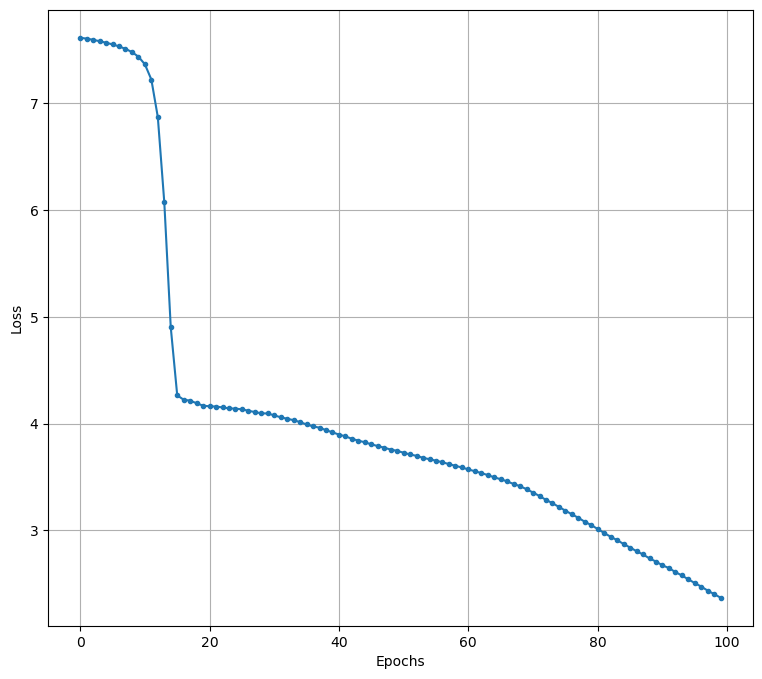

In [197]:
draw_history(history)

### Крок 4: Генерація тексту

- Писательское имя Бориса Васильева не нуждается в представлении 
- На 171-м разъезде уцелело двенадцать дворов, пожарный сарай да приземистый длинный пакгауз, выстроенный в начале века 

In [209]:
def predict_next_word(input_text, top = 10):
    tokenized_input = vectorizer([input_text])[:, :-1]
    prediction = model.predict(tokenized_input)
    predicted_ids = np.argsort(prediction[0])[-top:][::-1]

    for predicted_id in predicted_ids:
        print(vectorizer.get_vocabulary()[predicted_id])


In [ ]:
predict_next_word("Майор увез не выдержавших искуса")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
и
зенитчиков
часа
он
Не
на
рыжая
светятся
всего
добилась


## Завдання для самостійного виконання


### Прогнозування часових рядів:
- Використайте інші часові ряди (наприклад, дані про температуру, фондові ринки або продажі) для прогнозування.
- Експериментуйте з іншими архітектурами RNN, такими як LSTM та GRU, та порівняйте їх з SimpleRNN.
- Спробуйте змінити параметри моделі, такі як кількість шарів, кількість нейронів у шарах, та глибину історії (look_back), і проаналізуйте вплив цих змін на результати прогнозування.
- Використайте методи крос-валідації для оцінки точності моделі.

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 128)            │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,225 (266.50 KB)

 Trainable params: 68,225 (266.50 KB)

 Non-trainable params: 0 (0.00 B)

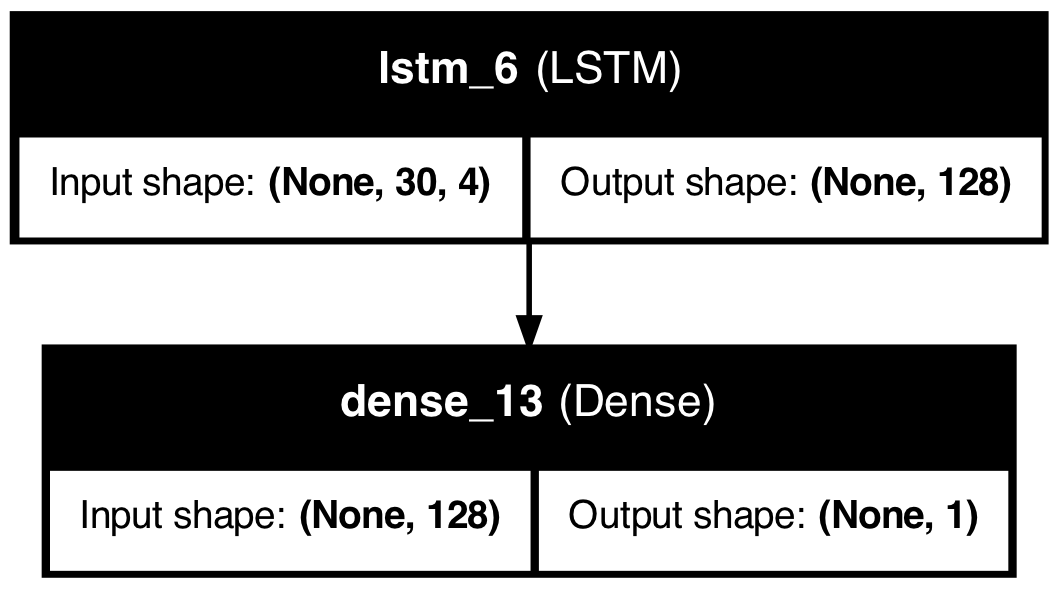

In [113]:
model_lstm = Sequential()
model_lstm.add(Input(shape=INPUT_SHAPE))
model_lstm.add(LSTM(UNITS))
model_lstm.add(Dense(1))

model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.summary()
plot_model(model_lstm, to_file="model_lstm.png", show_shapes=True, show_layer_names=True)

In [114]:
history_lstm = model_lstm.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, callbacks=[earlyStopping])

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0796 
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0254
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0204
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0219
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0198
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0179
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0183
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0212
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0211
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0218


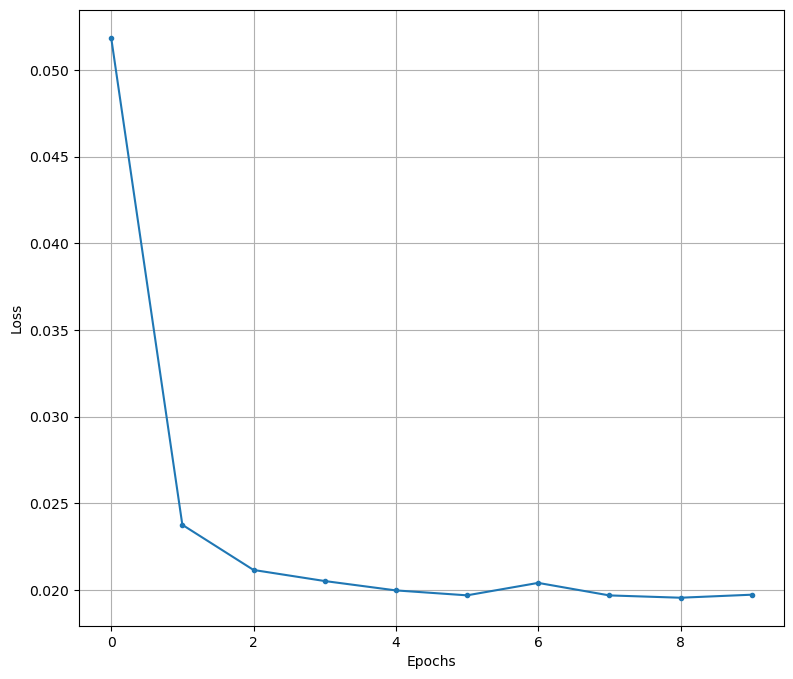

In [115]:
draw_history(history_lstm)

In [116]:
female_birth_predictions = model_lstm.predict(x_train)

female_birth_predictions

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


array([[0.29327902],
       [0.30750772],
       [0.3031619 ],
       [0.28494424],
       [0.25713655],
       [0.2371743 ],
       [0.21423902],
       [0.20456047],
       [0.19021297],
       [0.19146161],
       [0.18896237],
       [0.17700747],
       [0.18019457],
       [0.17869802],
       [0.17863725],
       [0.19088046],
       [0.19110174],
       [0.19919106],
       [0.20907803],
       [0.21819   ],
       [0.23056257],
       [0.23585464],
       [0.24837865],
       [0.25800812],
       [0.25721762],
       [0.26723805],
       [0.27477422],
       [0.28588986],
       [0.29557523],
       [0.30630305],
       [0.29945794],
       [0.28992918],
       [0.26494977],
       [0.24960485],
       [0.23271853],
       [0.2122104 ],
       [0.2032571 ],
       [0.19987904],
       [0.20022146],
       [0.19569272],
       [0.19145711],
       [0.19296028],
       [0.19842647],
       [0.20717002],
       [0.21422212],
       [0.21657486],
       [0.21368901],
       [0.214

In [ ]:
from sklearn.metrics import mean_squared_error

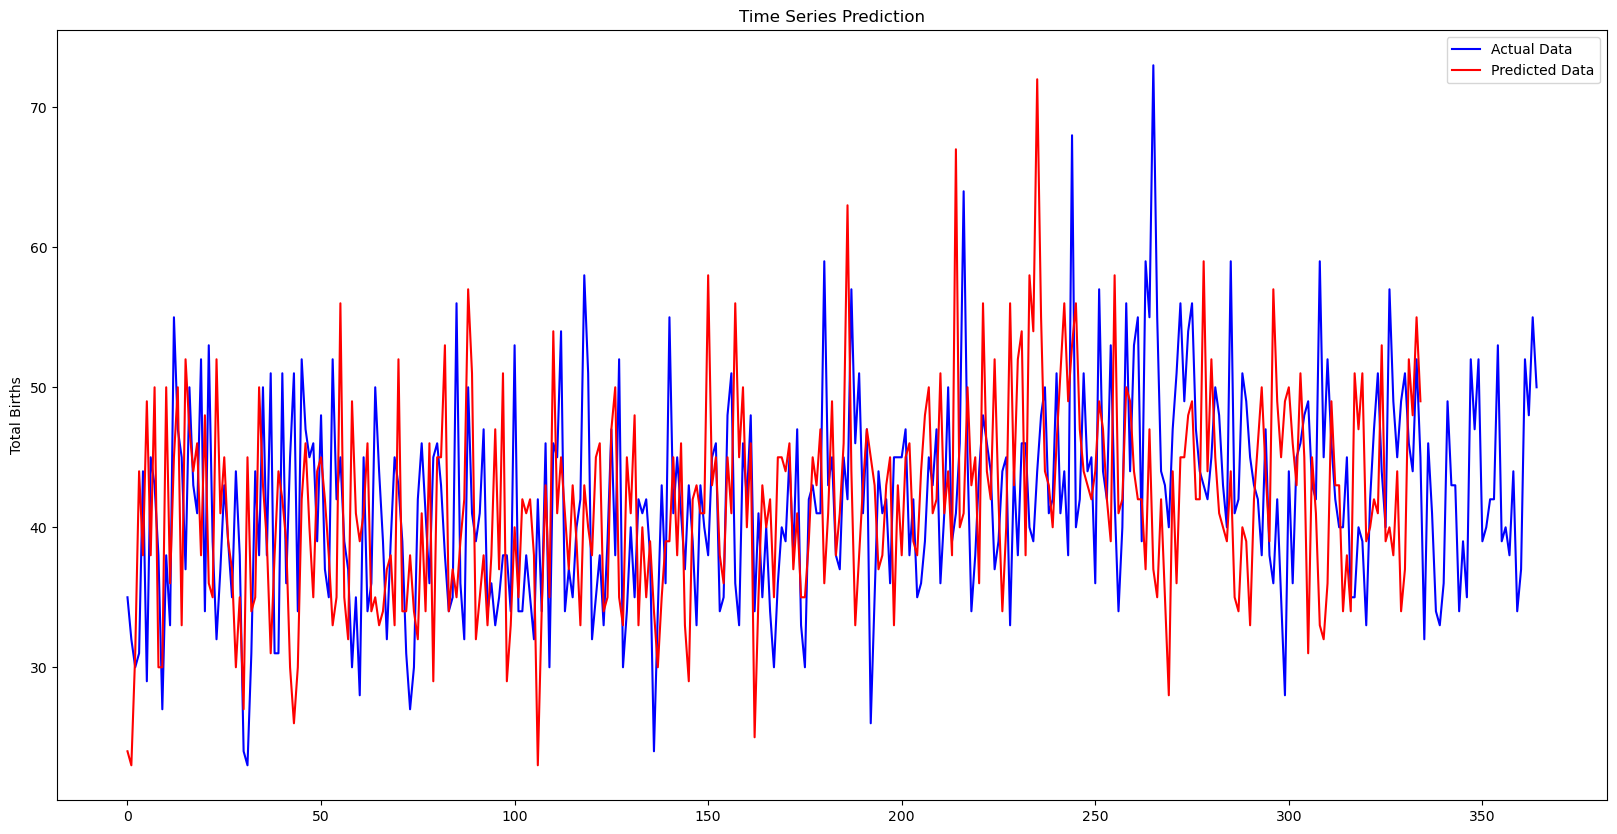

In [117]:
draw_predictions(female_births_target_array, inverted_female_birth_predictions)

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 128)            │        51,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,585 (201.50 KB)

 Trainable params: 51,585 (201.50 KB)

 Non-trainable params: 0 (0.00 B)

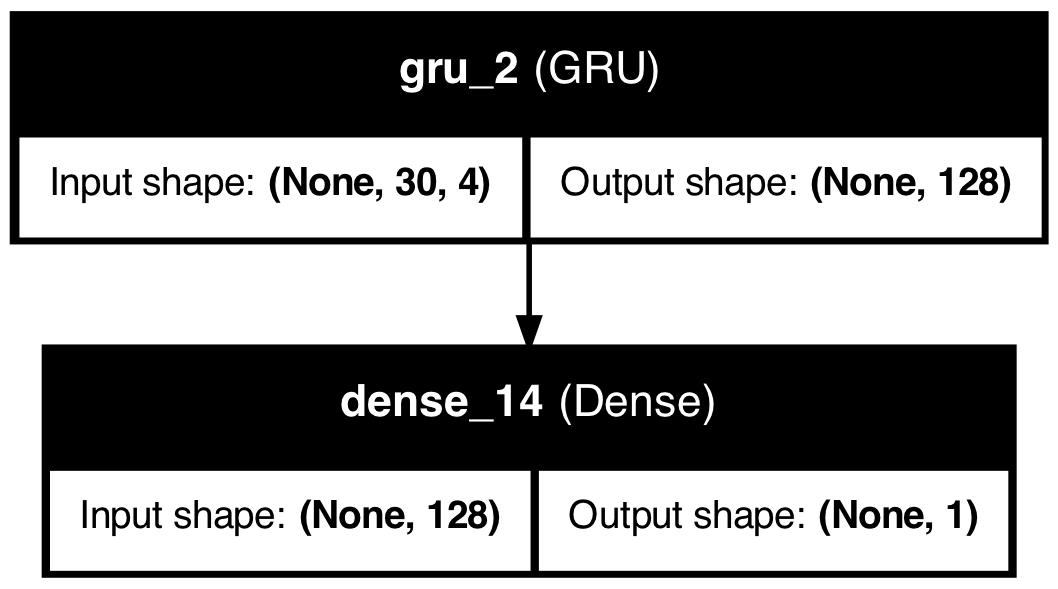

In [118]:
model_gru = Sequential()
model_gru.add(Input(shape=INPUT_SHAPE))
model_gru.add(GRU(UNITS))
model_gru.add(Dense(1))

model_gru.compile(optimizer='adam', loss='mean_squared_error')
model_gru.summary()
plot_model(model_gru, to_file="model_gru.png", show_shapes=True, show_layer_names=True)

In [119]:
history_gru = model_gru.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, callbacks=[earlyStopping])

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0886 
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0275
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0257
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0226
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0216
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0210
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0188
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0188
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0194
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0211


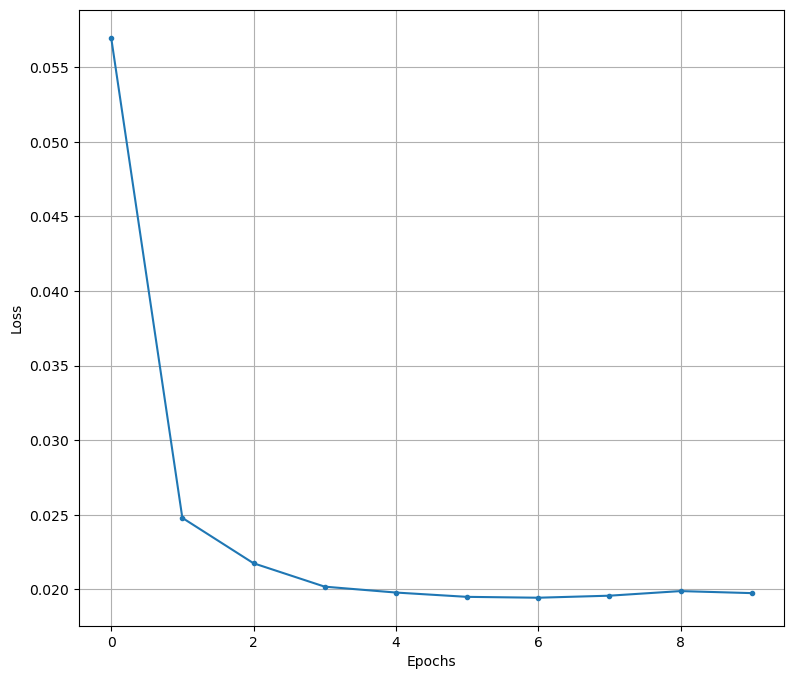

In [120]:
draw_history(history_gru)

In [121]:
female_birth_predictions = model_gru.predict(x_train)

female_birth_predictions

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


array([[0.461737  ],
       [0.44471046],
       [0.35671023],
       [0.29967055],
       [0.2869914 ],
       [0.27949873],
       [0.29725057],
       [0.29877576],
       [0.31960002],
       [0.3090392 ],
       [0.29490805],
       [0.3187809 ],
       [0.32350847],
       [0.33936116],
       [0.3661798 ],
       [0.3633769 ],
       [0.38530046],
       [0.4020821 ],
       [0.4123303 ],
       [0.4220793 ],
       [0.41993162],
       [0.43195418],
       [0.42885113],
       [0.42120573],
       [0.44423792],
       [0.4553313 ],
       [0.4675646 ],
       [0.4694367 ],
       [0.46684167],
       [0.4542991 ],
       [0.39036706],
       [0.33063486],
       [0.31584594],
       [0.29887834],
       [0.29067692],
       [0.31190953],
       [0.32745892],
       [0.33170202],
       [0.32242927],
       [0.3253992 ],
       [0.34287265],
       [0.358642  ],
       [0.3656742 ],
       [0.35761222],
       [0.34287563],
       [0.3369368 ],
       [0.35676435],
       [0.387

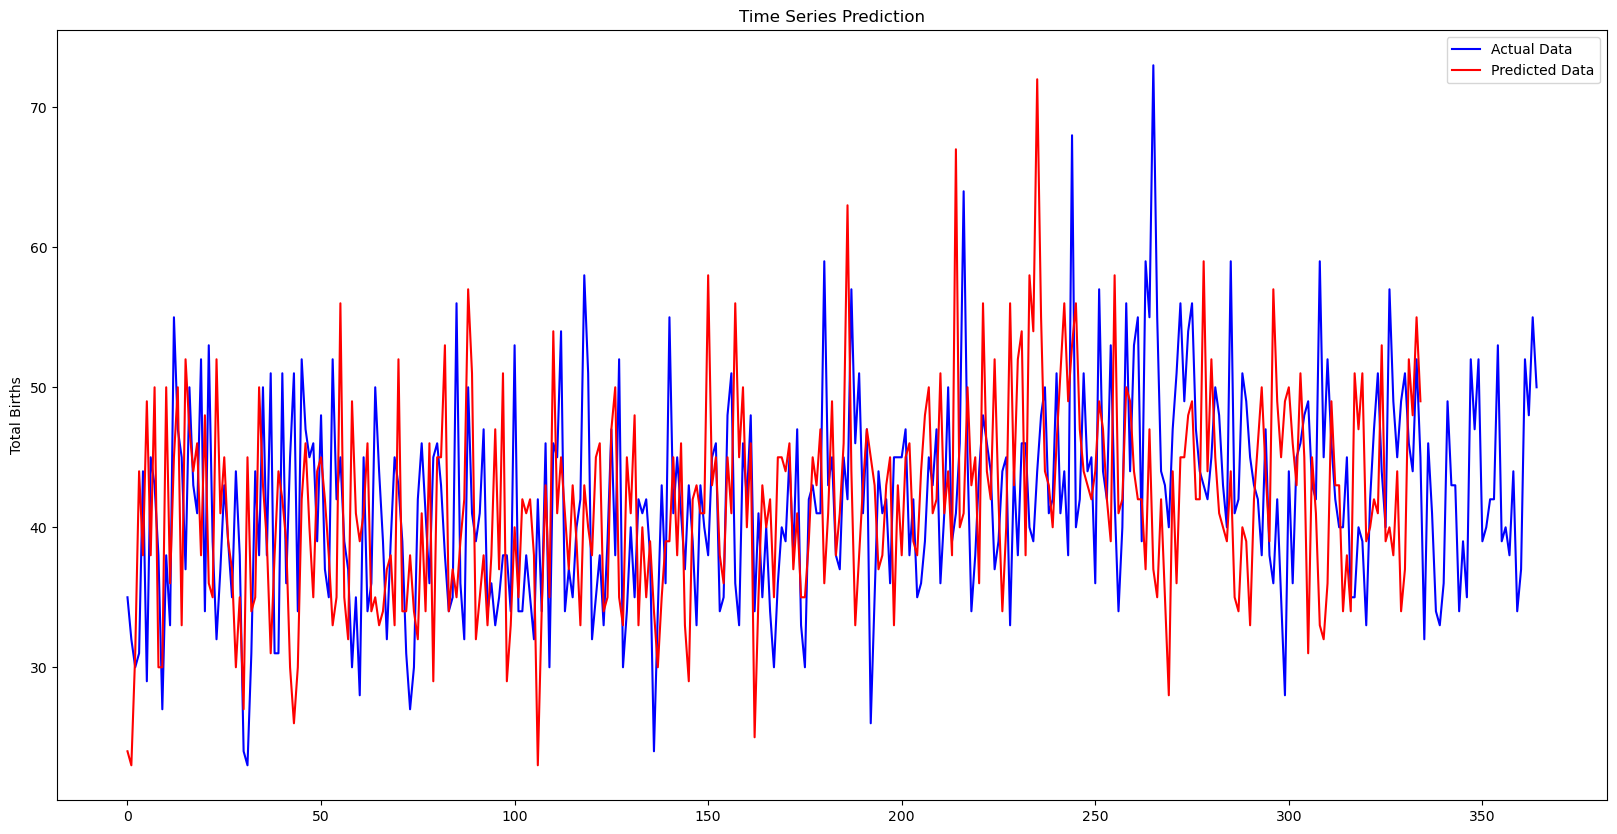

In [122]:
draw_predictions(female_births_target_array, inverted_female_birth_predictions)

### Генерація тексту:
- Використайте інші текстові дані (наприклад, книги, статті або пісні) для генерування тексту.
- Спробуйте змінити архітектуру моделі, додавши більше шарів LSTM або використовуючи інші рекурентні шари.
- Експериментуйте зі зміною кількості нейронів у шарах, розміром вбудованого шару (Embedding), та кількістю епох навчання, і проаналізуйте вплив цих змін на результати генерації тексту.
- Використайте різні початкові фрази для генерації тексту та проаналізуйте, як вони впливають на результати.

### Додаткове завдання:
- Реалізуйте візуалізацію навчального процесу (зміна втрат на кожній епосі) для обох моделей (часові ряди і текст).

### Теоретичне завдання:

- Дослідіть та поясніть, як працюють рекурентні нейронні мережі (RNN), довготривалі короткочасні пам'яті (LSTM) та мережі з блоками ГРУ (GRU). Напишіть коротке есе про їх відмінності та області застосування.
- Дослідіть питання перенавчання (overfitting) у RNN моделях. Опишіть методи боротьби з перенавчанням, такі як регуляризація та використання dropout шарів.

### 